In [137]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras.models import model_from_json, Sequential
import os
from sklearn.model_selection import train_test_split
import csv
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import json

In [ ]:
gibberish = pd.read_csv("./Gibberish.csv", encoding = "ISO-8859-1")
amazon = pd.read_csv("./Amazon.csv", encoding = "ISO-8859-1")

In [ ]:
gibberish.head()

In [ ]:
amazon.head()

In [ ]:
amazon.drop(amazon.columns[0], inplace=True, axis=1)
amazon.columns = ["Response"]
amazon["Label"] = 0
amazon.head()

In [ ]:
len(gibberish), len(amazon)

In [ ]:
def remove_intro(x):
  if x.find(":") < 0:
    return x
  else:
    return x[x.find(":") + 1:len(x)].strip()

In [ ]:
amazon["Response"] = amazon["Response"].apply(remove_intro)

In [ ]:
X = np.concatenate((amazon["Response"].values, gibberish["Response"].values))
Y = np.concatenate((amazon["Label"].values, gibberish["Label"].values))

In [ ]:
len(X), len(Y)

In [ ]:
pd.DataFrame({"Response": X, "Label" : Y} ).groupby("Label")["Response"].apply(lambda x: np.mean(x.str.len()))

In [ ]:
response_word_count = []

for i in range(len(X)):
  response_word_count.append(len(str(X[i])))
  
length_df = pd.DataFrame({"Response": response_word_count})
length_df.hist(bins=30)

plt.show()
np.percentile(response_word_count, 80), np.median(response_word_count)

In [ ]:
max_len = 256

In [ ]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X)

In [ ]:
tokenizer.word_index

In [ ]:
X = tokenizer.texts_to_sequences(X)

In [ ]:
X[1]

In [ ]:
X = pad_sequences(X, maxlen=max_len, padding="post")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.10)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size, 64),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dropout(rate=0.25),
    keras.layers.Dense(2, activation="softmax")
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [ ]:
history = model.fit(np.array(x_train), y_train, epochs=5, validation_data=(np.array(x_test), y_test), verbose=1)

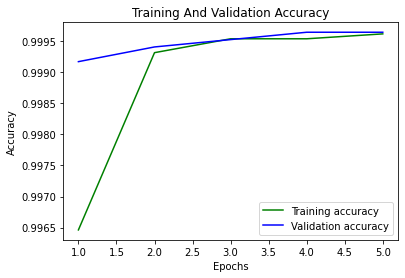

In [ ]:
loss_train = history.history['acc']
loss_val = history.history['val_acc']
epochs = range(1,6)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.title('Training And Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def predict_result(text):
    result = {0:"MEANINGFUL", 1: "GIBBERISH"}
    result = model.predict(pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_len, padding="post"))
    if (result[0][0] >= result[0][1]):
      return "MEANINGFUL"
    else:
      return "GIBBERISH"

'MEANINGFUL'

In [132]:
predict_result("Hello, I saw someone selling drugs in this corner")

'MEANINGFUL'

In [133]:
predict_result("efwefewfewewewew")

'GIBBERISH'

In [ ]:
model.save('./gibberish_detector')

['.config', 'gibberish_detector', 'Amazon.csv', 'Gibberish.csv', 'sample_data']


In [139]:
with open('tokenizer_config.json', 'w') as f:
  json.dump(json.loads(tokenizer.to_json()), f)